<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [1]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
bs = 32
labeled_bs = 32
test_bs = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005


batch_size = 512
temp = 0.1

contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [3]:
#get the cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#normalize
x_train = x_train/255
x_test = x_test/255

#lets devide the test to labeled train and test
x_train_labeled = x_test[:5000]
y_train_labeled = y_test[:5000]

x_test = x_test[5000:]
y_test = y_test[5000:]

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total training labeled images: {x_train_labeled.shape[0]} & Shape of training labeled data: {x_train_labeled.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total training labeled images: 5000 & Shape of training labeled data: (5000, 32, 32, 3)
Total testing images: 5000 & Shape of testing data: (5000, 32, 32, 3)


In [4]:
#class for image audmentations

class data_augmentation(layers.Layer):

  def __init__(self, **kwargs):
    super(data_augmentation, self).__init__()

  def call(self, sample):
    
    sample = self.random_apply(self.color_jitter, sample, 0.8)
    sample = self.random_apply(self.color_drop, sample, 0.2)    

    return sample

  def color_jitter(self, x, s = 1, p = 0.8):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta = 0.8 * s)
    x = tf.image.random_contrast(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta = 0.2 * s)
    x = tf.clip_by_value(x, 0, 1)
    return x

  def color_drop(self, x, p = 0.2):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 1, 3])
    return x

  def random_apply(self, func, x, p):
    return tf.cond(
      tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


#create the data augmentation pipline
data_aug = tf.keras.models.Sequential([tf.keras.layers.Lambda(data_augmentation()), tf.keras.layers.RandomCrop(24, 24), tf.keras.layers.Resizing(32, 32)])

In [5]:
#create tensorflow dataset objects

#create two datasets
train_ds_unlabeled = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_unlabeled = (train_ds_unlabeled.shuffle(1024, seed = random_seed).batch(bs).prefetch(AUTO))

train_ds_labeled = tf.data.Dataset.from_tensor_slices((x_train_labeled, y_train_labeled))
train_ds_labeled = (train_ds_labeled.shuffle(1024, seed = random_seed).batch(batch_size).prefetch(AUTO))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (test_ds.batch(batch_size).prefetch(AUTO))

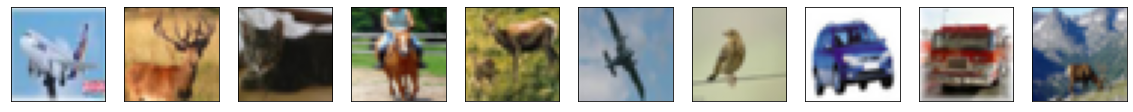

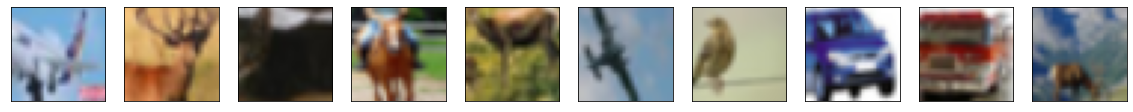

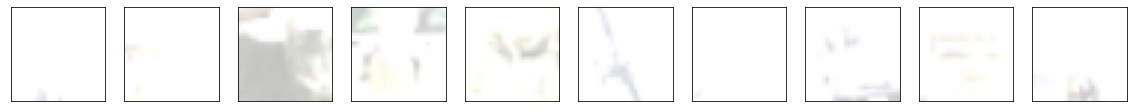

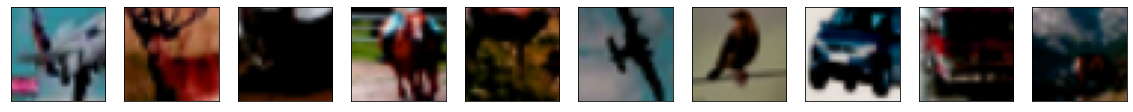

In [6]:
#checkout the augmentations
samp, lab = next(iter(train_ds_unlabeled))

def plot_images(samp):
  #plot figure
  fig, ax = plt.subplots(1, 10, figsize = (20, 2))
  
  for i, s in enumerate(samp[:10]):
    ax[i].imshow(s)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plot_images(samp)
plot_images(data_aug(samp))
plot_images(data_aug(samp))
plot_images(data_aug(samp))

In [7]:
#resnet 
def get_resnet():
  #get the resnet50 model
  base_model = tf.keras.applications.ResNet50(include_top = False, weights = None, input_shape = (32, 32, 3))
  base_model.trainable = True
  
  #define input
  inputs = tf.keras.layers.Input((32, 32, 3))

  #model
  x = base_model(inputs, training = True)
  x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  x = tf.keras.layers.Dense(512, activation = 'relu')(x)
  outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

  return tf.keras.Model(inputs, outputs)

In [8]:
#see the resnet50 model performance
resnet50 = get_resnet()

resnet50.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.SparseCategoricalCrossentropy(), 
                 metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'acc')])



In [9]:
#train the resnet50 model
base_history = resnet50.fit(train_ds_labeled, epochs = 20, validation_data = test_ds)

Epoch 1/20
10/10 [==============================] - 29s 1s/step - loss: 4.7568 - acc: 0.0988 - val_loss: 2.4999 - val_acc: 0.0994
Epoch 2/20
10/10 [==============================] - 5s 466ms/step - loss: 2.3977 - acc: 0.0957 - val_loss: 2.2799 - val_acc: 0.1012
Epoch 3/20
10/10 [==============================] - 5s 468ms/step - loss: 2.1675 - acc: 0.1016 - val_loss: 2.1088 - val_acc: 0.0996
Epoch 4/20
10/10 [==============================] - 5s 466ms/step - loss: 1.9755 - acc: 0.0970 - val_loss: 2.0644 - val_acc: 0.0993
Epoch 5/20
10/10 [==============================] - 5s 467ms/step - loss: 1.8247 - acc: 0.0983 - val_loss: 1.9825 - val_acc: 0.1000
Epoch 6/20
10/10 [==============================] - 5s 465ms/step - loss: 1.5411 - acc: 0.0984 - val_loss: 2.1386 - val_acc: 0.1000
Epoch 7/20
10/10 [==============================] - 5s 468ms/step - loss: 1.3537 - acc: 0.0991 - val_loss: 2.2244 - val_acc: 0.1002
Epoch 8/20
10/10 [==============================] - 5s 468ms/step - loss: 1.23

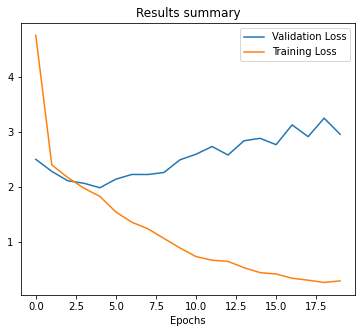

In [10]:
#plot
plt.figure(figsize = (6, 5))
plt.plot(np.arange(0, len(base_history.history['val_loss'])), base_history.history['val_loss'], label = 'Validation Loss')
plt.plot(np.arange(0, len(base_history.history['loss'])), base_history.history['loss'], label = 'Training Loss')
plt.legend()
plt.title('Results summary')
plt.xlabel('Epochs')
plt.show()

In [9]:
#contrastive learning 

#training step
@tf.function
def train_step(xi, xj, model, batch_size, optimizer, temp):
  with tf.GradientTape() as tape:

    #get zi and zj from the model
    zi = model(xi)
    zj = model(xj)

    #normalize zi and zj
    zi = tf.math.l2_normalize(zi, axis = 1)
    zj = tf.math.l2_normalize(zj, axis = 1)

    #similarity calculation
    similarities = tf.matmul(zi, zj, transpose_b = True)/temp
    similarities = tf.reshape(similarities, (batch_size, 1))

    return None   